In [4]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy.io import savemat

subjins25_csv = pd.read_csv('SubjIns25alltime.csv', header=None)
subjins25_data = subjins25_csv.values
subjins25_data = np.delete(subjins25_data, [0, 5, 10], axis=0)

# subjFFA25_csv = pd.read_csv('SubjFFA25alltime.csv', header=None)
subjglu25_csv = pd.read_csv('Subjglu25alltime.csv', header=None)

subjglu25_data = subjglu25_csv.values
subjglu25_data = np.delete(subjglu25_data, [3, 21], axis=0)



# Set random seed for reproducibility
torch.manual_seed(241126)

# Define the training data
train_x = torch.tensor([0.,2.,3.,4.,5.,6.,8.,10.,12.,14.,16.,19.,22., 24., 25., 27., 30., 40., 50., 60., 70., 80., 90., 100.,
                        120., 140., 160., 180.], dtype=torch.float32)
subjglu25 = torch.tensor(subjglu25_data, dtype=torch.float32)

train_mean = torch.mean(torch.log(subjglu25), dim=0)
train_std = torch.std(torch.log(subjglu25), dim=0)

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel(
                alpha_prior=gpytorch.priors.SmoothedBoxPrior(0.8, 1.0),
                lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(0.01, 5.0)
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, None, likelihood)  # Set train_y to None initially

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.001)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100000
loss_threshold = 0.6
stop_training = False

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    random_row_idx = torch.randint(0, subjglu25.shape[0], (1,))
    train_y = (torch.log(subjglu25[random_row_idx]) - train_mean) / train_std

    # Output from model
    output = model(train_x)
    # Calculate loss and backpropagate gradients
    loss = -mll(output, train_y)
    loss.backward()
    if (i + 1) % 100 == 0:
        max_loss_idx = random_row_idx
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f  Max Loss Row: %d' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item(),
            max_loss_idx.item()
        ))
        # Check if the loss is below the threshold
    if loss.item() < loss_threshold:
        print('Loss is below the threshold. Stopping training.')
        stop_training = True
        break

    optimizer.step()

    # Check if the iteration exceeds the limit
    if i + 1 >= training_iter:
        print('Exceeded maximum iterations. Stopping training.')
        stop_training = True
        break

if stop_training:
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    num_samples = 300
    total_samples = 10000

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = train_x
        observed_pred = likelihood(model(test_x))

    # Generate new samples
    new_test_x = train_x
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        new_samples = observed_pred.sample(torch.Size([total_samples]))
        pred_mean_rescaledback = torch.exp(observed_pred.mean * train_std + train_mean)
        lower_rescaledback = torch.exp(observed_pred.confidence_region()[0] * train_std + train_mean)
        upper_rescaledback = torch.exp(observed_pred.confidence_region()[1] * train_std + train_mean)

    new_samples_rescaled = torch.exp(new_samples * train_std + train_mean)
    print(new_samples_rescaled.shape)

    new_samples_rescaled_double = new_samples_rescaled.double()

    xdatanp = np.array(train_x.unsqueeze(0))


Iter 100/100000 - Loss: 1.710   lengthscale: 0.735   noise: 0.650  Max Loss Row: 9
Iter 200/100000 - Loss: 1.359   lengthscale: 0.784   noise: 0.609  Max Loss Row: 1
Iter 300/100000 - Loss: 1.542   lengthscale: 0.835   noise: 0.570  Max Loss Row: 2
Iter 400/100000 - Loss: 1.234   lengthscale: 0.889   noise: 0.532  Max Loss Row: 15
Iter 500/100000 - Loss: 1.313   lengthscale: 0.938   noise: 0.492  Max Loss Row: 8
Iter 600/100000 - Loss: 1.085   lengthscale: 1.000   noise: 0.457  Max Loss Row: 11
Iter 700/100000 - Loss: 1.372   lengthscale: 1.056   noise: 0.422  Max Loss Row: 10
Iter 800/100000 - Loss: 1.023   lengthscale: 1.117   noise: 0.391  Max Loss Row: 14
Iter 900/100000 - Loss: 1.001   lengthscale: 1.174   noise: 0.360  Max Loss Row: 12
Iter 1000/100000 - Loss: 1.134   lengthscale: 1.231   noise: 0.331  Max Loss Row: 8
Iter 1100/100000 - Loss: 0.937   lengthscale: 1.293   noise: 0.304  Max Loss Row: 19
Iter 1200/100000 - Loss: 1.215   lengthscale: 1.355   noise: 0.279  Max Loss Ro

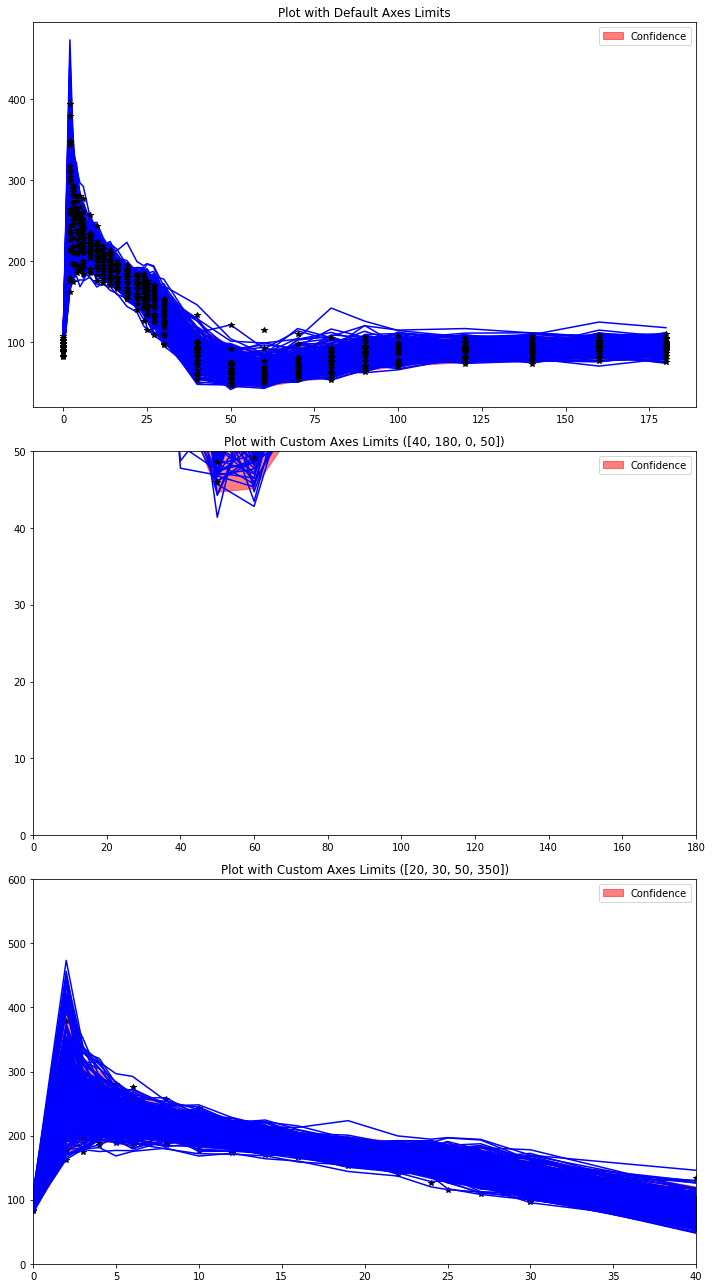

In [5]:
# Plot the new samples
f, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot the generated samples
for i in range(num_samples):
    axs[0].plot(new_test_x.numpy(), new_samples_rescaled[i].numpy(), 'b')

# Manually plot the confidence interval as a shaded region
confidence_region = axs[0].fill_between(test_x.numpy(), lower_rescaledback.numpy(),
                                        upper_rescaledback.numpy(), color='red', alpha=0.5)

for i in range(subjglu25.shape[0]):
    training_data = axs[0].plot(xdatanp, subjglu25[i].unsqueeze(0).numpy(), 'k*')



# Add the confidence region to the legend
axs[0].legend([confidence_region], ['Confidence'], loc='upper right')
axs[0].set_title('Plot with Default Axes Limits')

# Set axes limits for the second plot
axs[1].set_xlim([0, 180])
axs[1].set_ylim([0, 50])

# Plot the generated samples
for i in range(num_samples):
    axs[1].plot(new_test_x.numpy(), new_samples_rescaled[i].numpy(), 'b')

# Manually plot the confidence interval as a shaded region
confidence_region = axs[1].fill_between(test_x.numpy(), lower_rescaledback.numpy(),
                                        upper_rescaledback.numpy(), color='red', alpha=0.5)

# Plot rescaled training data as black stars
for i in range(subjglu25.shape[0]):
    training_data = axs[1].plot(xdatanp, subjglu25[i].unsqueeze(0).numpy(), 'k*')

# Add the confidence region to the legend
axs[1].legend([training_data[0]], ['Training data'], loc='upper right')
axs[1].legend([confidence_region], ['Confidence'], loc='upper right')
axs[1].set_title('Plot with Custom Axes Limits ([40, 180, 0, 50])')

# Set axes limits for the third plot
axs[2].set_xlim([0, 40])
axs[2].set_ylim([0, 600])

# Plot rescaled training data as black stars
for i in range(subjglu25.shape[0]):
    training_data = axs[2].plot(xdatanp, subjglu25[i].unsqueeze(0).numpy(), 'k*')

# Plot the generated samples
for i in range(num_samples):
    axs[2].plot(new_test_x.numpy(), new_samples_rescaled[i].numpy(), 'b')

# Manually plot the confidence interval as a shaded region
confidence_region = axs[2].fill_between(test_x.numpy(), lower_rescaledback.numpy(),
                                        upper_rescaledback.numpy(), color='red', alpha=0.5)

# Add the confidence region to the legend
axs[2].legend([confidence_region], ['Confidence'], loc='upper right')
axs[2].set_title('Plot with Custom Axes Limits ([20, 30, 50, 350])')

plt.tight_layout()
plt.show()


In [ ]:
savemat('confidence_data_glu0125.mat', {
    'test_x': test_x.numpy(),
    'lower_rescaledback': lower_rescaledback.numpy(),
    'upper_rescaledback': upper_rescaledback.numpy(),
    'subjglu25': subjglu25.numpy()
})


In [ ]:
from scipy.io import savemat

# Convert new_samples_rescaled to double precision
new_samples_rescaled_double = new_samples_rescaled.double()

# Save samples to a MATLAB-compatible mat file as double precision
savemat('****SAVE YOUR GLUCOSE GPR SAMPLES HERE****.mat', {'samples': new_samples_rescaled_double.numpy()})
